In [2]:
import os
import os.path
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sb

## Data

The data is stored in CSV files. Each experiment has normal and abnormal data. Multiple runs residing in the same folder correspond to the same behavior (either normal or the same anomaly).

In [3]:
DATADIR = "data"
EXPERIMENTS = ["real_panda", "sim_panda", "real_turtlebot3", "sim_turtlebot3"]

def normal_datadir(experiment):
    """Returns normal data directory for the experiment.
    """
    return os.path.join(DATADIR, experiment, "normal\\type1")

def abnormal_datadirs(experiment):
    """Returns the list of anomaly names and corresponding data directories
    for the experiment.
    """
    abnormal = os.path.join(DATADIR, experiment, "abnormal")
    datadirs = []
    for entry in os.listdir(abnormal):
        dir = os.path.join(abnormal, entry)
        if os.path.isdir(dir):
            datadirs.append((entry, dir))
    return datadirs

Let us list all experiments with their directories and anomalies.

In [4]:
for exp in EXPERIMENTS:
    print(f"Experiment: {exp}")
    print(normal_datadir(exp))
    for anomaly, dir in abnormal_datadirs(exp):
        print(f"{anomaly} => {dir}")
    print()


Experiment: real_panda
data/real_panda/normal
gripper_attack => data/real_panda/abnormal/gripper_attack
change_obj_weight => data/real_panda/abnormal/change_obj_weight
low_net_connection => data/real_panda/abnormal/low_net_connection
miss_bubble => data/real_panda/abnormal/miss_bubble

Experiment: sim_panda
data/sim_panda/normal
gripper_attack => data/sim_panda/abnormal/gripper_attack
collision => data/sim_panda/abnormal/collision
drop_early => data/sim_panda/abnormal/drop_early

Experiment: real_turtlebot3
data/real_turtlebot3/normal
unmapped_obstacle => data/real_turtlebot3/abnormal/unmapped_obstacle
velocity_attack => data/real_turtlebot3/abnormal/velocity_attack
hardware_fault => data/real_turtlebot3/abnormal/hardware_fault
low_net_connection => data/real_turtlebot3/abnormal/low_net_connection
collision => data/real_turtlebot3/abnormal/collision

Experiment: sim_turtlebot3
data/sim_turtlebot3/normal
unmapped_obstacle => data/sim_turtlebot3/abnormal/unmapped_obstacle
velocity_attack

 Inside the files, columns with counters have names starting with 'Counter'.

In [5]:
def read_data_file(fname):
    df = pd.read_csv(fname)
    df = df.filter(regex="^Counter\(", axis=1)
    return df

In [6]:
df = read_data_file("data/real_panda/normal/type1/panda_normal6.csv")

For KS statistics-based comparison, we only need the set of non-zero counts.

In [7]:
def non_zero_counts(df):
    """Returns a list of non-zero counts in the data frame.
    """
    counts = df.to_numpy()
    return counts[counts > 1].reshape(-1)

In [8]:
def dir_counts(datadir):
    """Returns list of lists of counts for a data directory.
    """
    counts = []
    for entry in os.listdir(datadir):
        path = os.path.join(datadir, entry)
        if os.path.isfile(path):
            counts.append(non_zero_counts(read_data_file(path)))
    return counts

## Statistics

Using the above, we compute Kolmogorov-Smirnov statistics between any sets of runs and a set of counts of all runs of a particular type, the baseline. Usually, the later will be the union of all normal runs, the training set.

In [9]:
def ks_statistics_of_runs(counts, baseline):
    return np.array([ss.ks_2samp(c, baseline).statistic for c in counts])

Let us demonstrate this on each experiment. For each experiment, we compare the KS statistics of anomalous runs to the KS statistics of normal runs, relative to all normal runs.

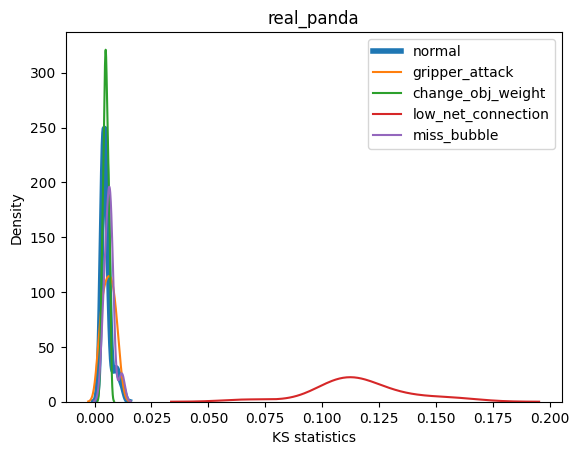

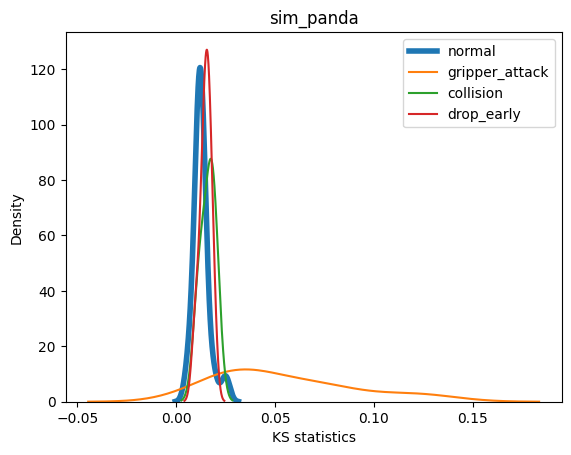

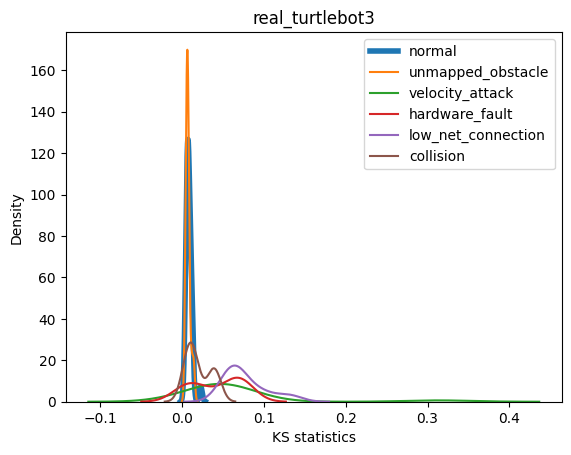

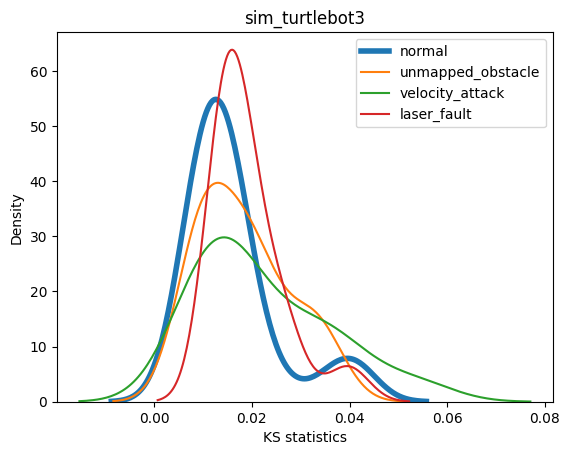

In [10]:
for exp in EXPERIMENTS:
    normal_counts = dir_counts(normal_datadir(exp))
    baseline = np.concatenate(normal_counts)
    abnormal_counts = []
    for abname, abpath in abnormal_datadirs(exp):
        abnormal_counts.append((abname, dir_counts(abpath)))

    plt.title(exp)
    plt.xlabel("KS statistics")
    sb.kdeplot(ks_statistics_of_runs(normal_counts, baseline), lw=4, label="normal")
    for abname, abcounts in abnormal_counts:
        sb.kdeplot(ks_statistics_of_runs(abcounts, baseline), label=abname)
    plt.legend()
    plt.show()

The plots above suggest that the anomalies are, in general, indentifiable to some extent using the KS statistics between count distributions. However, these plots are obstructed by "strong" anomalies, such that KS is so large the rest is compressed to the left. Let's remove the easiest anomalies and see what happens with the rest.

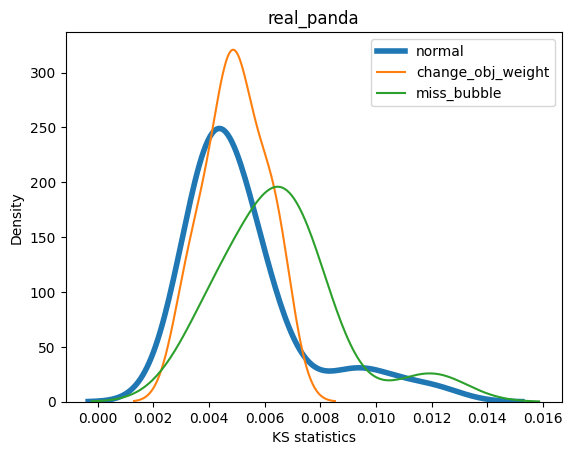

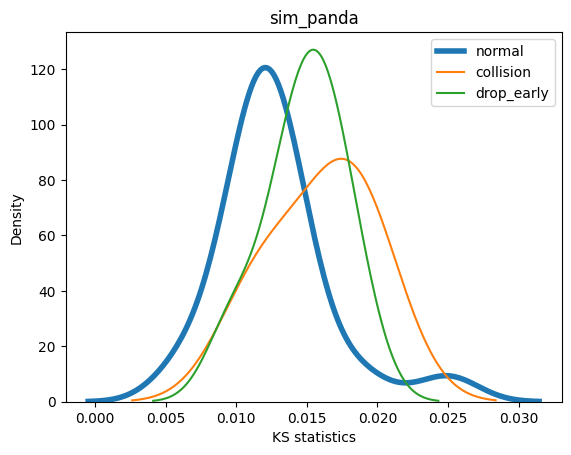

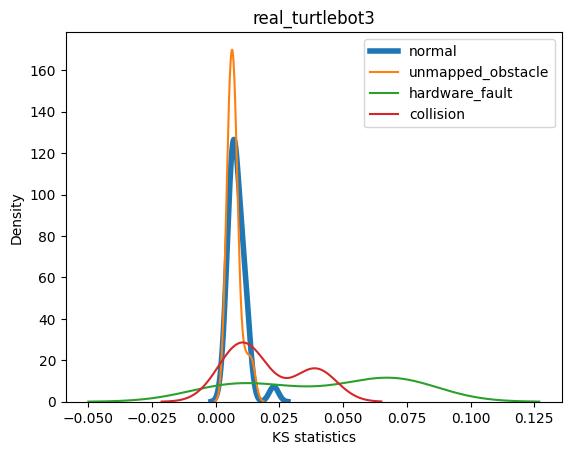

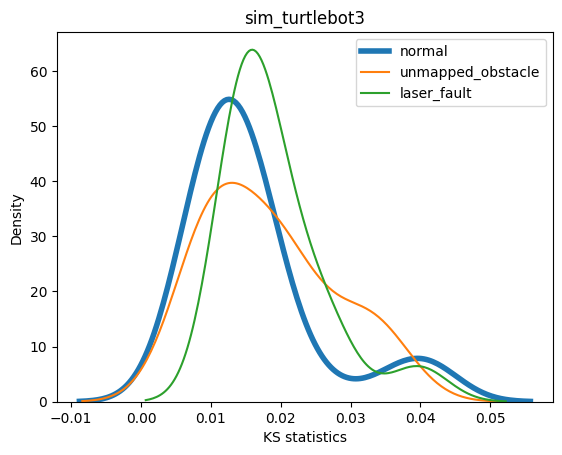

In [11]:
for exp in EXPERIMENTS:
    normal_counts = dir_counts(normal_datadir(exp))
    baseline = np.concatenate(normal_counts)
    abnormal_counts = []
    for abname, abpath in abnormal_datadirs(exp):
        if abname in ["gripper_attack", "low_net_connection", "velocity_attack"]:
            continue
        abnormal_counts.append((abname, dir_counts(abpath)))

    plt.title(exp)
    plt.xlabel("KS statistics")
    sb.kdeplot(ks_statistics_of_runs(normal_counts, baseline),  lw=4, label="normal")
    for abname, abcounts in abnormal_counts:
        sb.kdeplot(ks_statistics_of_runs(abcounts, baseline), label=abname)
    plt.legend()
    plt.show()

Not bad, even with the easily detectable anomalies removed, the anomalous runs have greater KS statistics on average than the normal ones, relative to the total normal run distribution.

Let us now do the opposite and answer the question how good is the method, qualitatively, for detecting _any_, rather than each, anomaly. We will merge all anomalous runs together, and each plot will have just two densities, normal and anomalous.

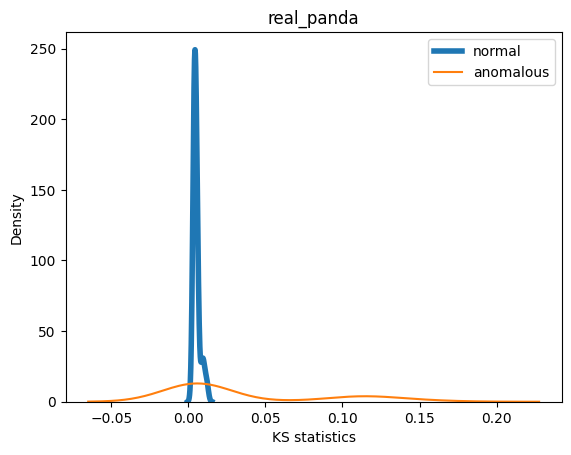

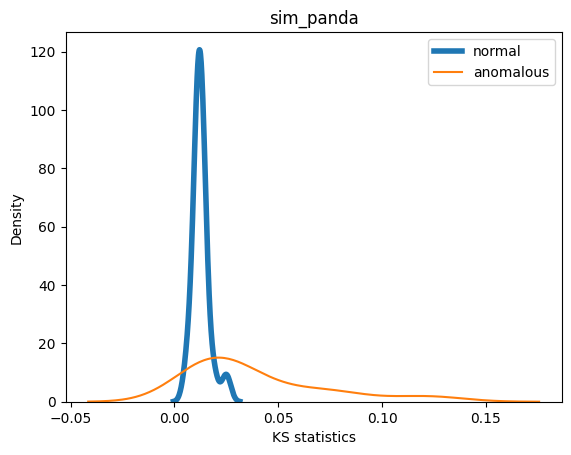

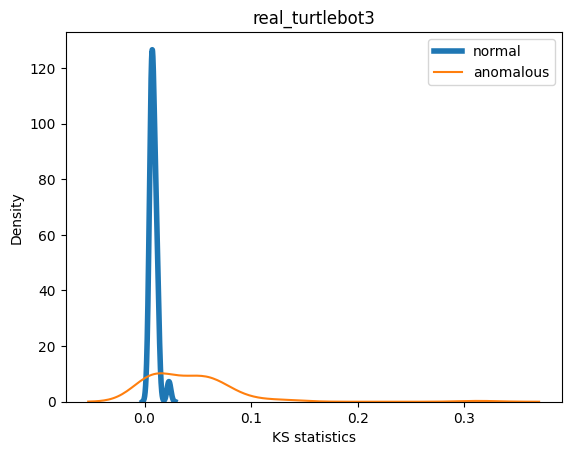

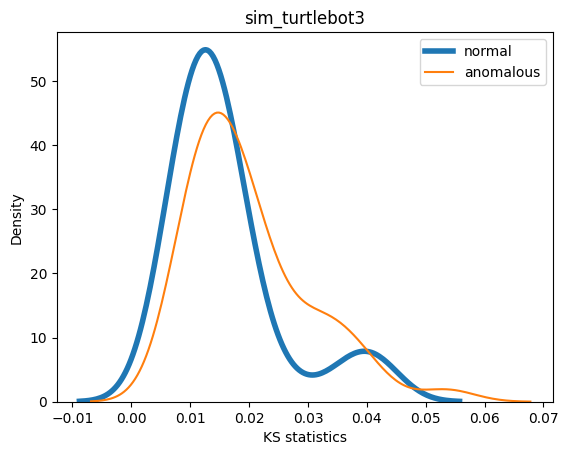

In [12]:
for exp in EXPERIMENTS:
    normal_counts = dir_counts(normal_datadir(exp))
    baseline = np.concatenate(normal_counts)
    abnormal_counts = []
    for abname, abpath in abnormal_datadirs(exp):
        abnormal_counts.append((abname, dir_counts(abpath)))

    plt.title(exp)
    plt.xlabel("KS statistics")
    sb.kdeplot(ks_statistics_of_runs(normal_counts, baseline), lw=4, label="normal")
    all_abcounts = []
    for abname, abcounts in abnormal_counts:
        all_abcounts.extend(abcounts)
    sb.kdeplot(ks_statistics_of_runs(all_abcounts, baseline), label="anomalous")
    plt.legend()
    plt.show()

The above should depend, of course, on the probability of each anomaly, but even with uniform probabilities, the KS-statistics-based detecting should be informative in most cases, on its own or along with other statistics.

## Area Under Curve

To quantitatively characterize the predictive power of the KS statistics, we compute the area under the precision-recall curve.

In [13]:
def confusion_matrices(normal_counts_train, 
                       normal_counts_test, abnormal_counts_test,
                       N=25):
    """Computes confusion matrices for an anomaly. Arguments:
       * normal_counts_train --- normal counts used for choosing the KS threshold.
       * normal_counts_test --- normal counts test set.
       * abnormal_counts_test --- abnormal counts test set.
       * N --- number of points to calculate ROC at.
    Returns:
       confusion matrices for a range of thresholds.
    """
    baseline = np.concatenate(normal_counts_train)
    
    normal_ks_train = ks_statistics_of_runs(normal_counts_train, baseline)
    thresholds = np.linspace(normal_ks_train.max(),  normal_ks_train.min(), 25)

    normal_ks_test = ks_statistics_of_runs(normal_counts_test, baseline)
    abnormal_ks_test = ks_statistics_of_runs(abnormal_counts_test, baseline)

    cs = []
    for th in thresholds:
        c = np.array(
            [[sum(normal_ks_test < th), sum(normal_ks_test >= th)],
             [sum(abnormal_ks_test < th), sum(abnormal_ks_test >= th)]])
        cs.append(c)

    return np.stack(cs, axis=0)


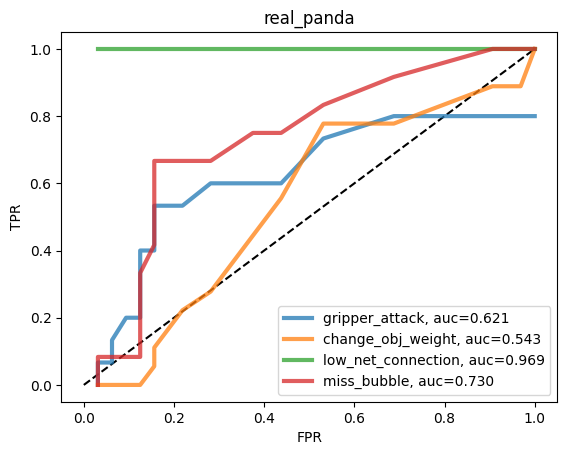

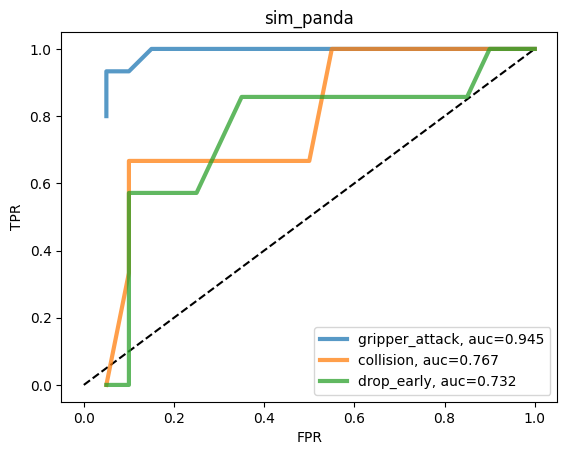

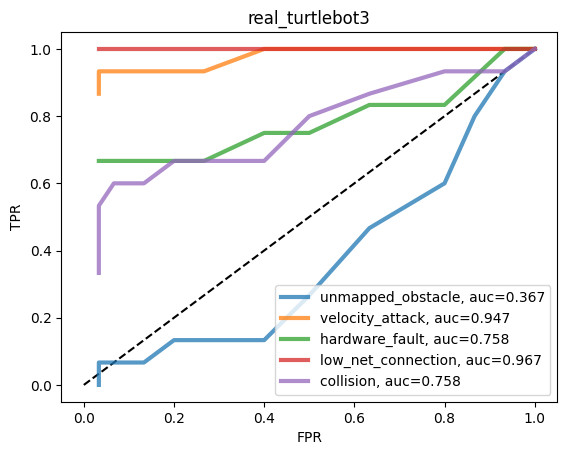

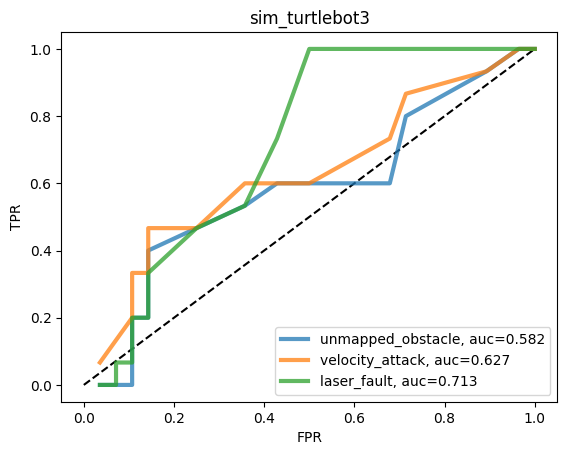

In [14]:
for exp in EXPERIMENTS:
    plt.plot([0, 1], [0, 1], ls="dashed", c="black")
    plt.title(exp)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    normal_counts = dir_counts(normal_datadir(exp))
    for abname, abpath in abnormal_datadirs(exp):
        abnormal_counts = dir_counts(abpath)
        cs = confusion_matrices(normal_counts,
                                normal_counts,
                                abnormal_counts)
        tpr = cs[:, 1, 1] / (cs[:, 1, 0] + cs[:, 1, 1])
        fpr = cs[:, 0, 1] / (cs[:, 0, 0] + cs[:, 0, 1])
        auc = np.trapz(tpr, fpr)
        plt.plot(fpr, tpr, lw=3, alpha=0.75, label=f"{abname}, auc={auc:.3f}")
    
    plt.legend()
    plt.savefig(f"{exp}-roc.png")
    plt.show()

_=_

## Cross-validation

To complete the analysis, we run multi-fold cross-validation  on the normal data. In each fold, we use a part of the normal data to compute the ROC AUC on the rest of the normal data and all the anomalous data. We report the mean and the standard deviation of the ROC AUC for each anomaly.

In [15]:
NFOLDS = 10
print(f"{'experiment/anomaly':34s} | {'mean':5s} | {'sd':5s}") 
print("-" * 50)
for exp in EXPERIMENTS:
    normal_counts = dir_counts(normal_datadir(exp))
    fold_size = len(normal_counts) // NFOLDS
    for abname, abpath in abnormal_datadirs(exp):
        abnormal_counts = dir_counts(abpath)
        s = 0
        s2 = 0
        for i in range(NFOLDS):
            normal_counts_train = normal_counts[:i * fold_size] + normal_counts[(i + 1) * fold_size:]
            normal_counts_test = normal_counts[i*fold_size:(i+1)*fold_size]
            cs = confusion_matrices(normal_counts_train,
                                    normal_counts_test,
                                    abnormal_counts)
            tpr = cs[:, 1, 1] / (cs[:, 1, 0] + cs[:, 1, 1])
            fpr = cs[:, 0, 1] / (cs[:, 0, 0] + cs[:, 0, 1])
            auc = np.trapz(tpr, fpr)
            s+= auc
            s2 += auc*auc
        mean_auc = s / NFOLDS
        std_auc = np.sqrt(s2 / NFOLDS - mean_auc * mean_auc) * NFOLDS / (NFOLDS - 1)
        print(f"{exp + '/' + abname:34s} | {mean_auc:.3f} | {std_auc:.3f}")

experiment/anomaly                 | mean  | sd   
--------------------------------------------------
real_panda/gripper_attack          | 0.573 | 0.115
real_panda/change_obj_weight       | 0.481 | 0.161
real_panda/low_net_connection      | 0.933 | 0.148
real_panda/miss_bubble             | 0.669 | 0.133
sim_panda/gripper_attack           | 0.890 | 0.227
sim_panda/collision                | 0.642 | 0.278
sim_panda/drop_early               | 0.639 | 0.288
real_turtlebot3/unmapped_obstacle  | 0.317 | 0.190
real_turtlebot3/velocity_attack    | 0.908 | 0.148
real_turtlebot3/hardware_fault     | 0.706 | 0.143
real_turtlebot3/low_net_connection | 0.933 | 0.148
real_turtlebot3/collision          | 0.719 | 0.158
sim_turtlebot3/unmapped_obstacle   | 0.528 | 0.158
sim_turtlebot3/velocity_attack     | 0.578 | 0.154
sim_turtlebot3/laser_fault         | 0.607 | 0.197


The table above confirms that for most anomalies AUC is significantly greater than 0.5. This means that KS statistic can be used as an informative statistic for anomaly detection, on its own or in ensemble with other detectors.